# Optimizer test

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [38]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [6]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [7]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view(scaled_data, window_size, axis=0).transpose(0,2,1)[:-1]
    output_data = scaled_data[window_size:,1]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(split*len(data))
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [18]:
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
hub = keras.losses.Huber()

def eval_model(model, history, type, loss='mae', optimizer='AdamW'):
    y_pred = model.predict(X_test)
    res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
    sns.lineplot(res, dashes=False)
    plt.show()
    
    pd.DataFrame(history.history).plot()
    plt.show()

    #print(f"Best val loss: {min(history.history['val_loss'])}")
    
    return {
        'type': type,
        'best_val_loss': min(history.history['val_loss']),
        'loss_method': loss,
        'optimizer': optimizer,
        'mae': mae(y_test, y_pred).numpy(),
        'mse': mse(y_test, y_pred).numpy(),
        'huber': hub(y_test, y_pred).numpy(),
    }

def res_to_table(result):
    return pd.DataFrame.from_dict(result, orient='index').T

In [42]:
results = []

In [10]:
scaler = MinMaxScaler((-1,1))
data = np.array(df)
((X_train, y_train), (X_test, y_test)) = prepare_data(data, scaler)

In [34]:
def simpleRNN(optimizer):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.SimpleRNN(50),
        keras.layers.Dense(1),
    ])
    
    model.summary()
    
    epochs = 300
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'SimpleRNN_1layer', optimizer=optimizer.__class__.__name__)
    display(res_to_table(res))
    results.append(res)


In [35]:
def lstm(optimizer):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.LSTM(50),
        keras.layers.Dense(1),
    ])
    
    model.summary()
    
    epochs = 800
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'LSTM_1layer', optimizer=optimizer.__class__.__name__)
    display(res_to_table(res))
    results.append(res)
    

In [36]:
def gru(optimizer):
    model = tf.keras.models.Sequential([
        keras.layers.Input(shape=(50,6)),
        keras.layers.GRU(50, return_sequences=True),
        keras.layers.GRU(50),
        keras.layers.Dense(1),
    ])
    
    epochs = 600
    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=80, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    res = eval_model(model, history, 'GRU_2layer', optimizer=optimizer.__class__.__name__)
    display(res_to_table(res))
    results.append(res)

## Testiranje

Testing model simpleRNN with optimizer SGD:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 20ms/step - loss: 0.1841 - val_loss: 0.0307 - lr: 0.0100
Epoch 2/300
25/25 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0196 - lr: 0.0100
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0153 - lr: 0.0100
Epoch 4/300
25/25 [==============

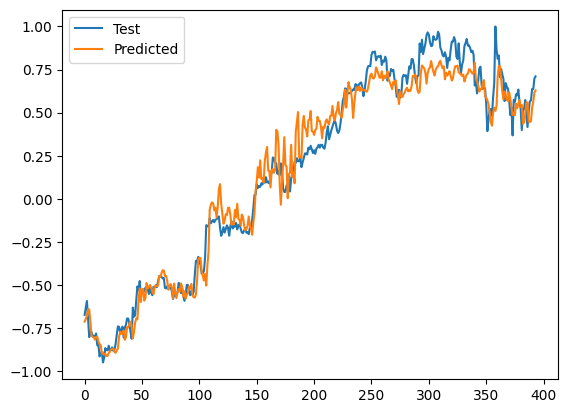

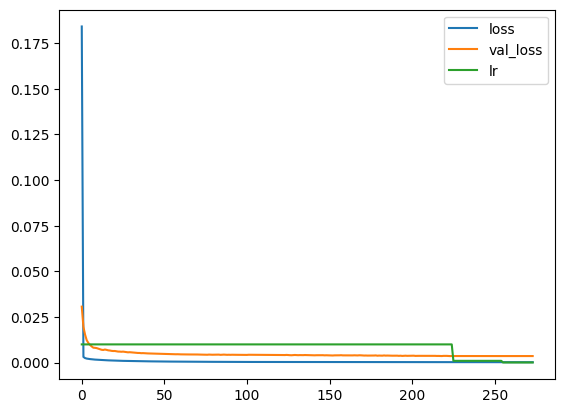

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.0036,mae,SGD,0.083074,0.011437,0.005718,0.661503


--------------


Testing model lstm with optimizer SGD:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11400     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 16ms/step - loss: 0.0801 - val_loss: 0.2043 - lr: 0.0100
Epoch 2/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.1266 - lr: 0.0100
Epoch 3/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0840 - lr: 0.0100
Epoch 4/800
25/25 [==

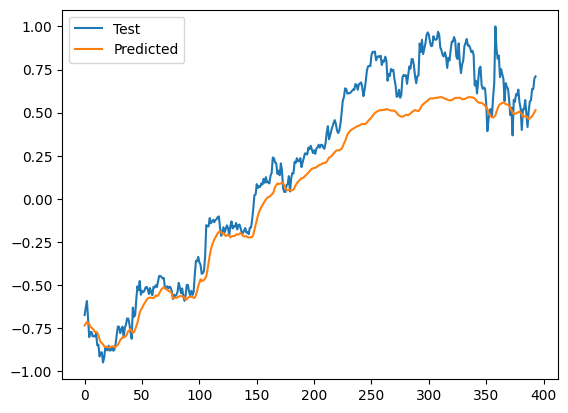

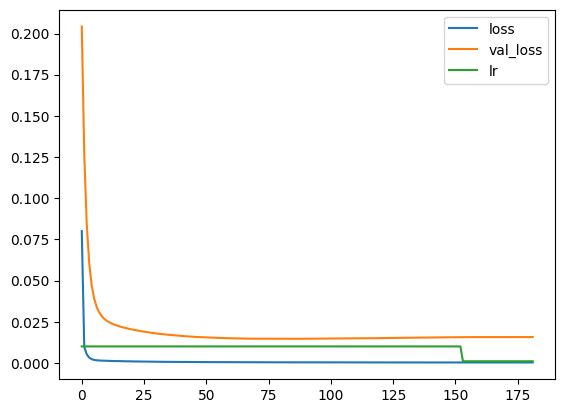

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,LSTM_1layer,0.014574,mae,SGD,0.140419,0.030666,0.015333,0.710302


--------------


Testing model gru with optimizer SGD:
Epoch 1/600
25/25 [==============================] - 3s 23ms/step - loss: 0.0714 - val_loss: 0.2168 - lr: 0.0100
Epoch 2/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.1093 - lr: 0.0100
Epoch 3/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0641 - lr: 0.0100
Epoch 4/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0438 - lr: 0.0100
Epoch 5/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0338 - lr: 0.0100
Epoch 6/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0286 - lr: 0.0100
Epoch 7/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0256 - lr: 0.0100
Epoch 8/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0233 - lr: 0.0100
Epoch 9/600
25/25 [=============================

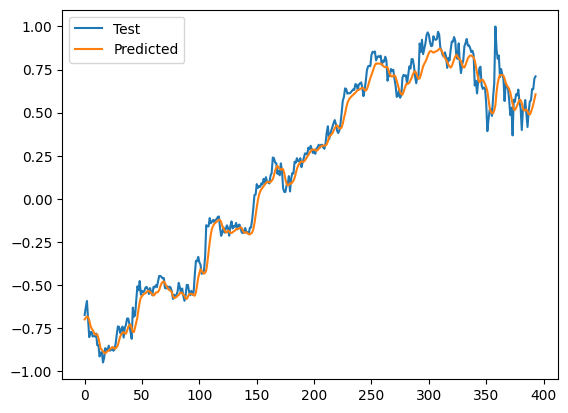

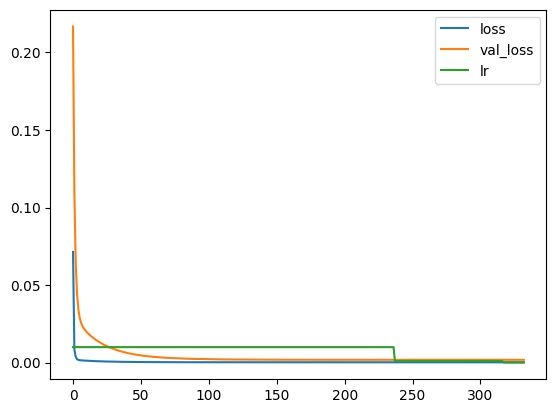

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,GRU_2layer,0.001819,mae,SGD,0.052363,0.005285,0.002642,0.650169


--------------


Testing model simpleRNN with optimizer Lion:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 1s 21ms/step - loss: 0.0944 - val_loss: 0.0234 - lr: 1.0000e-04
Epoch 2/300
25/25 [==============================] - 0s 17ms/step - loss: 0.0354 - val_loss: 0.0752 - lr: 1.0000e-04
Epoch 3/300
25/25 [==============================] - 0s 16ms/step - loss: 0.0124 - val_loss: 0.0081 - lr: 1.0000e-04
Ep

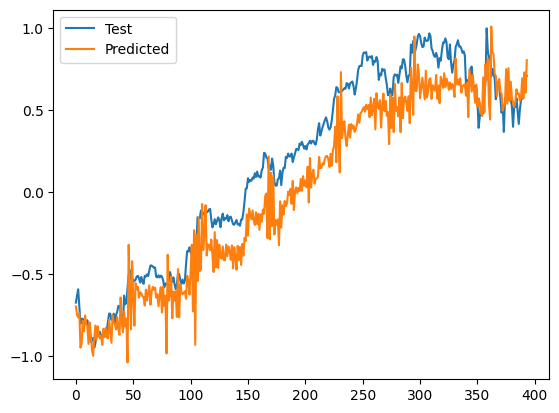

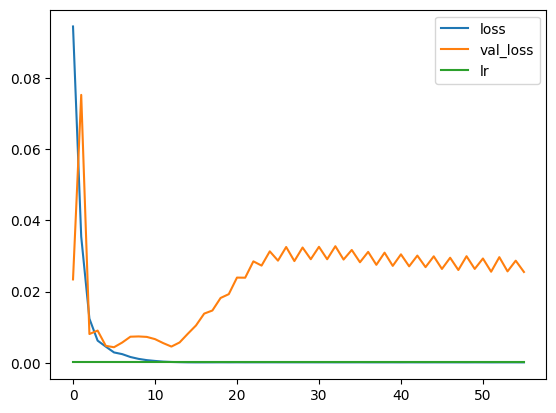

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.004384,mae,Lion,0.182693,0.044843,0.022421,0.686853


--------------


Testing model lstm with optimizer Lion:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11400     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 1s 15ms/step - loss: 0.2477 - val_loss: 0.0293 - lr: 1.0000e-04
Epoch 2/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0798 - val_loss: 0.0195 - lr: 1.0000e-04
Epoch 3/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0133 - lr: 1.0000e-04
Epoch 4

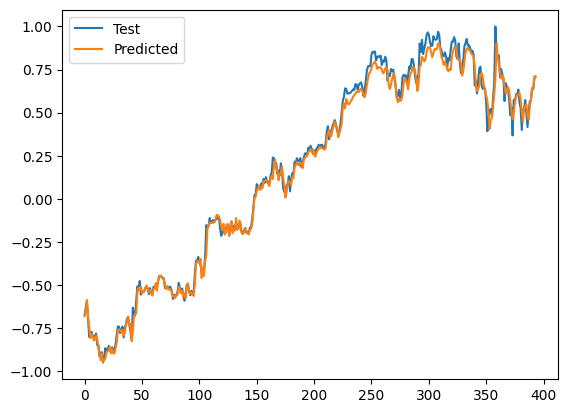

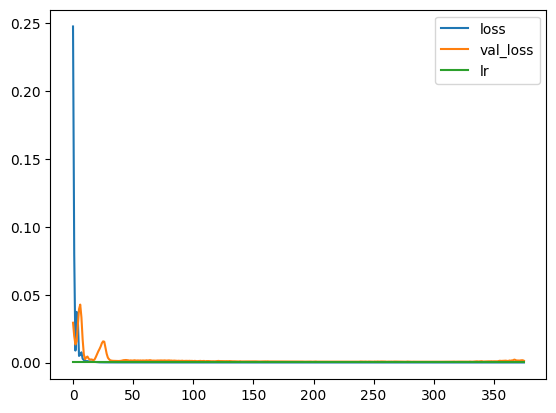

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,LSTM_1layer,0.000552,mae,Lion,0.033517,0.002155,0.001078,0.649659


--------------


Testing model gru with optimizer Lion:
Epoch 1/600
25/25 [==============================] - 2s 24ms/step - loss: 0.0669 - val_loss: 0.0188 - lr: 1.0000e-04
Epoch 2/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0036 - lr: 1.0000e-04
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0052 - lr: 1.0000e-04
Epoch 4/600
25/25 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0058 - lr: 1.0000e-04
Epoch 5/600
25/25 [==============================] - 0s 7ms/step - loss: 5.7436e-04 - val_loss: 0.0076 - lr: 1.0000e-04
Epoch 6/600
25/25 [==============================] - 0s 6ms/step - loss: 4.8218e-04 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 7/600
25/25 [==============================] - 0s 6ms/step - loss: 3.6188e-04 - val_loss: 0.0033 - lr: 1.0000e-04
Epoch 8/600
25/25 [==============================] - 0s 6ms/step - loss: 2.3654e-04 - val_loss: 0.0014 - lr: 1.0000e-04

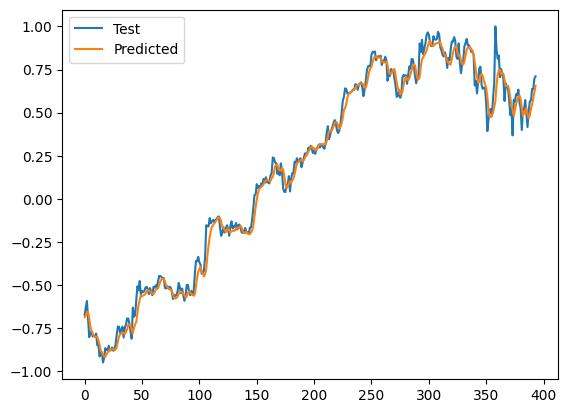

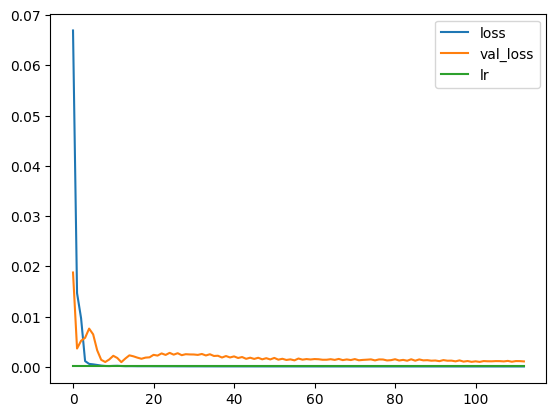

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,GRU_2layer,0.000924,mae,Lion,0.039967,0.003402,0.001701,0.642239


--------------


Testing model simpleRNN with optimizer Adafactor:
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 50)                2850      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2901 (11.33 KB)
Trainable params: 2901 (11.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 2s 20ms/step - loss: 0.3607 - val_loss: 0.5367 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 0s 17ms/step - loss: 0.0437 - val_loss: 0.0849 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0270 - lr: 0.0010
Epoch 4/3

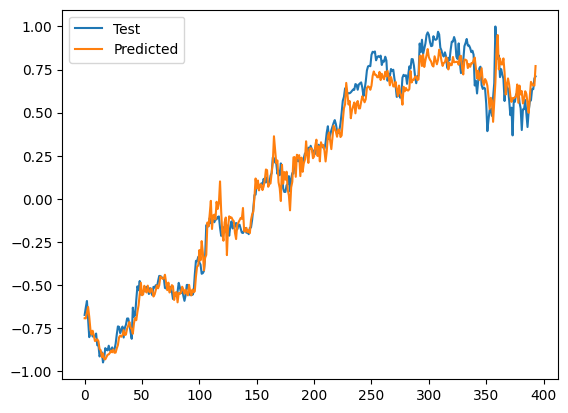

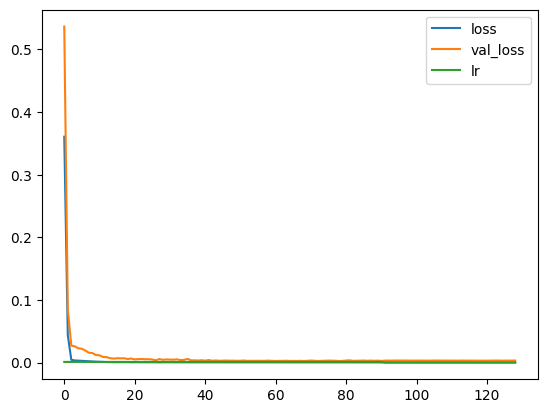

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.002404,mae,Adafactor,0.063031,0.006434,0.003217,0.65328


--------------


Testing model lstm with optimizer Adafactor:
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                11400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
25/25 [==============================] - 2s 31ms/step - loss: 0.1493 - val_loss: 0.2028 - lr: 0.0010
Epoch 2/800
25/25 [==============================] - 0s 4ms/step - loss: 0.0387 - val_loss: 0.1658 - lr: 0.0010
Epoch 3/800
25/25 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.1122 - lr: 0.0010
Epoch 4/800
25

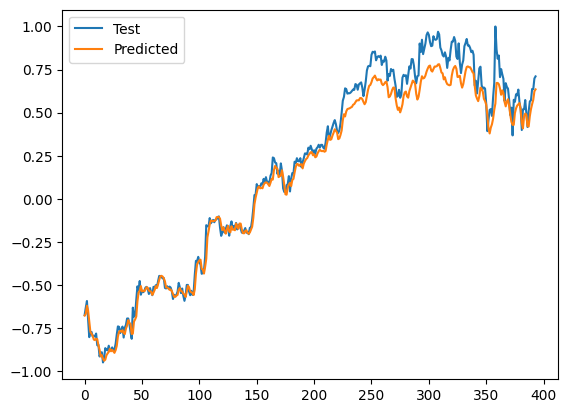

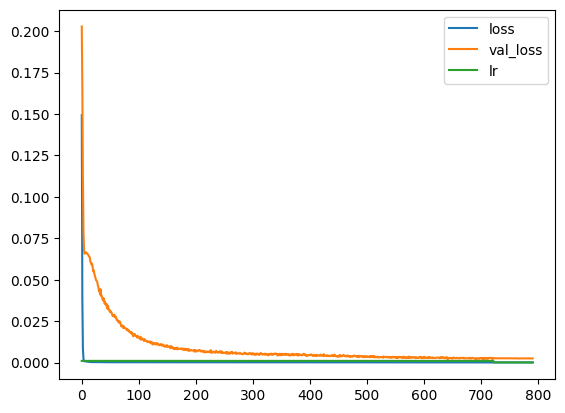

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,LSTM_1layer,0.002082,mae,Adafactor,0.064001,0.00751,0.003755,0.675357


--------------


Testing model gru with optimizer Adafactor:
Epoch 1/600
25/25 [==============================] - 3s 25ms/step - loss: 0.3052 - val_loss: 0.1484 - lr: 0.0010
Epoch 2/600
25/25 [==============================] - 0s 10ms/step - loss: 0.1432 - val_loss: 0.1203 - lr: 0.0010
Epoch 3/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0373 - val_loss: 0.0840 - lr: 0.0010
Epoch 4/600
25/25 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0476 - lr: 0.0010
Epoch 5/600
25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0276 - lr: 0.0010
Epoch 6/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0193 - lr: 0.0010
Epoch 7/600
25/25 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0155 - lr: 0.0010
Epoch 8/600
25/25 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0129 - lr: 0.0010
Epoch 9/600
25/25 [=====================

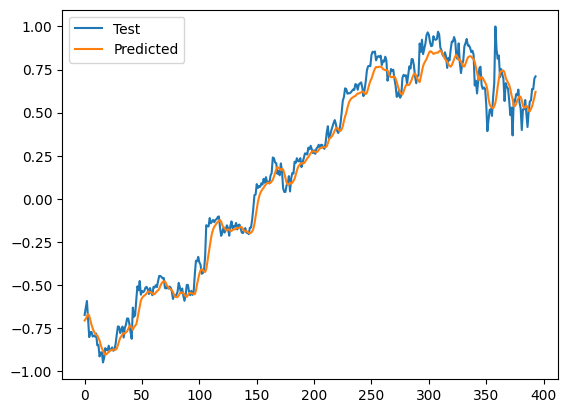

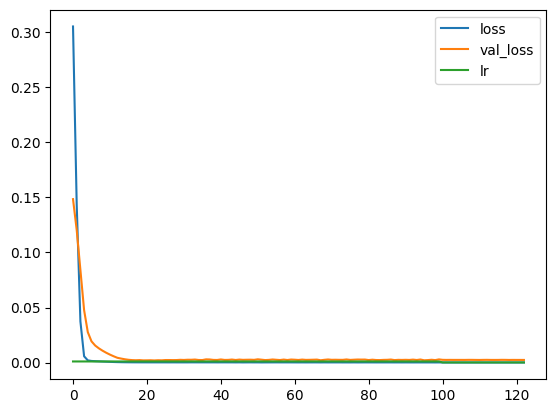

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,GRU_2layer,0.001935,mae,Adafactor,0.056796,0.005858,0.002929,0.651577


--------------




In [43]:
optimizers = [
    keras.optimizers.SGD,
    keras.optimizers.Lion,
    keras.optimizers.Adafactor,
]
for optimizer in optimizers:
    for model_fn in [simpleRNN, lstm, gru]:
        print(f'Testing model {model_fn.__name__} with optimizer {optimizer.__name__}:')
        model_fn(optimizer())
        print('--------------\n\n')

In [151]:
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(50,6)),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.SimpleRNN(50),
    keras.layers.Dense(1),
])

model.summary()

epochs = 300
batch_size = 128

callbacks = [
    #keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=30, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.1e-2),
    loss='mean_squared_error',
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 50, 50)            2850      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 7951 (31.06 KB)
Trainable params: 7951 (31.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 3s 49ms/step - loss: 0.0310 - val_loss: 0.0114 - lr: 0.0010
Epoch 2/300
25/25 [==============================] - 1s 40ms/step - loss: 0.0022 - val_loss: 0.0064 - lr: 0.0010
Epoch 3/300
25/25 [==============================] - 1s 4

## Rezultati

In [46]:
res = pd.DataFrame(results)
res

,type,best_val_loss,loss_method,optimizer,mae,mse,huber,hinge
0,SimpleRNN_1layer,0.003600,mae,SGD,0.083074,0.011437,0.005718,0.661503
1,LSTM_1layer,0.014574,mae,SGD,0.140419,0.030666,0.015333,0.710302
2,GRU_2layer,0.001819,mae,SGD,0.052363,0.005285,0.002642,0.650169
3,SimpleRNN_1layer,0.004384,mae,Lion,0.182693,0.044843,0.022421,0.686853
4,LSTM_1layer,0.000552,mae,Lion,0.033517,0.002155,0.001078,0.649659
5,GRU_2layer,0.000924,mae,Lion,0.039967,0.003402,0.001701,0.642239
6,SimpleRNN_1layer,0.002404,mae,Adafactor,0.063031,0.006434,0.003217,0.653280
7,LSTM_1layer,0.002082,mae,Adafactor,0.064001,0.007510,0.003755,0.675357
8,GRU_2layer,0.001935,mae,Adafactor,0.056796,0.005858,0.002929,0.651577


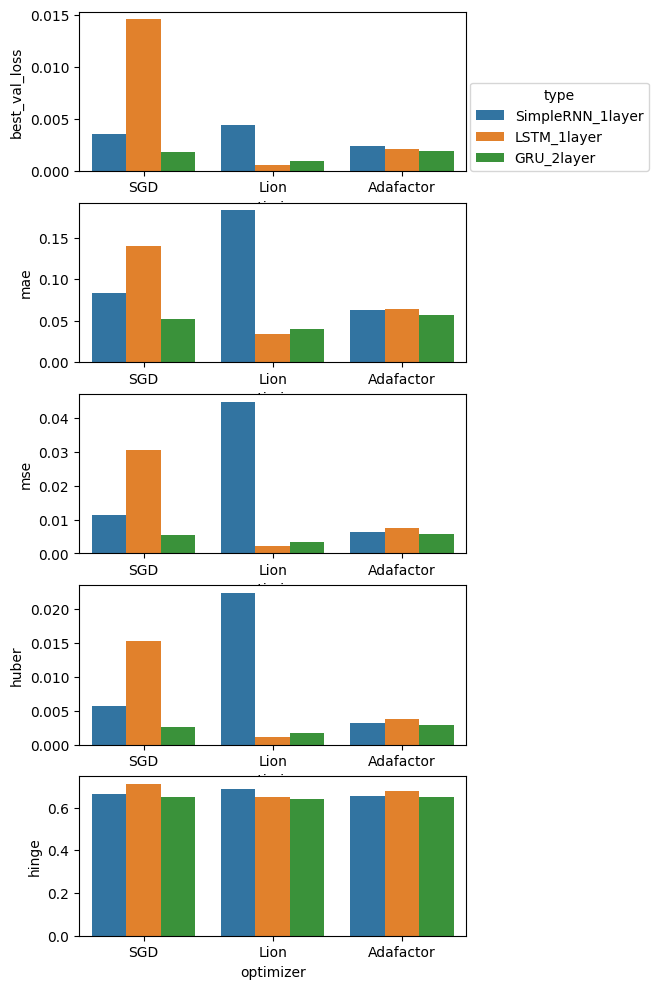

In [48]:
fig = plt.figure(figsize=(5,12))
axs = fig.subplots(nrows=5)
for i, col in enumerate(['best_val_loss', 'mae', 'mse', 'huber', 'hinge']):
    if i == 0:
        sns.move_legend(sns.barplot(res, hue='type', y=col, x='optimizer', ax=axs[i], legend=True), (1.01,0))
    else:
        sns.barplot(res, hue='type', y=col, x='optimizer', ax=axs[i], legend=False)

Svi rezultati su gori od AdamW.